## Prepare the data for the model used in the paper ##

Read each file and segment them into one hour windows. Each file will contain 28,800 samples per hour at an 8 Hz sampling rate.

In [5]:
import os
from obspy import read
import glob
import numpy as np
from obspy import UTCDateTime

# Define the processed and output folder paths
processed_folder = os.getcwd() + '/data/processed'
segmented_output_folder = os.getcwd() + '/data/segmented'
os.makedirs(segmented_output_folder, exist_ok=True)  # Create output directory if it doesn't exist

# Define the target segment duration (1 hour) in seconds
segment_duration = 3600  # seconds

# Process each processed file for segmentation
for file_path in glob.glob(f"{processed_folder}/*.mseed"):
    # Read the processed file
    st = read(file_path)
    
    # Normalize the traces in the stream object
    st.normalize()
    
    # Split each trace in the Stream object into one-hour segments
    for tr in st:
        start_time = tr.stats.starttime
        end_time = tr.stats.endtime
        segment_start = start_time

        # Loop over each one-hour segment
        while segment_start + segment_duration <= end_time:
            # Define the end time for the current segment
            segment_end = segment_start + segment_duration

            # Slice the trace to create a one-hour segment
            segment = tr.slice(starttime=segment_start, endtime=segment_end)
            
            # Format the filename for the segment
            segment_filename = f"{tr.stats.network}_{tr.stats.station}_{tr.stats.channel}_{segment_start.strftime('%Y%m%dT%H%M%S')}.mseed"
            segment_filepath = os.path.join(segmented_output_folder, segment_filename)
            
            # Avoid overwriting existing files
            if os.path.exists(segment_filepath):
                print(f"Segment already exists: {segment_filepath}")
                segment_start = segment_end  # Move to the next hour
                continue

            # Save the one-hour segment as a new file
            try:
                segment.write(segment_filepath, format="MSEED")
                print(f"Saved segment file: {segment_filepath}")
            except Exception as e:
                print(f"Error writing segment {segment_filepath}: {e}")

            # Move to the next hour
            segment_start = segment_end

            # # Save the one-hour segment as a new file
            # segment.write(segment_filepath, format="MSEED")
            # print(f'Saved segment file: {segment_filepath}')

            # # Move to the next hour
            # segment_start = segment_end

Segment already exists: /home/jen/snap/MLGEO2024_Geldingadalir/notebooks/NUPH_analysis/data/segmented/9F_NUPH_HHE_20210429T224800.mseed
Segment already exists: /home/jen/snap/MLGEO2024_Geldingadalir/notebooks/NUPH_analysis/data/segmented/9F_NUPH_HHE_20210429T234800.mseed
Segment already exists: /home/jen/snap/MLGEO2024_Geldingadalir/notebooks/NUPH_analysis/data/segmented/9F_NUPH_HHE_20210430T004800.mseed
Segment already exists: /home/jen/snap/MLGEO2024_Geldingadalir/notebooks/NUPH_analysis/data/segmented/9F_NUPH_HHE_20210430T014800.mseed
Segment already exists: /home/jen/snap/MLGEO2024_Geldingadalir/notebooks/NUPH_analysis/data/segmented/9F_NUPH_HHE_20210430T024800.mseed
Segment already exists: /home/jen/snap/MLGEO2024_Geldingadalir/notebooks/NUPH_analysis/data/segmented/9F_NUPH_HHE_20210430T034800.mseed
Segment already exists: /home/jen/snap/MLGEO2024_Geldingadalir/notebooks/NUPH_analysis/data/segmented/9F_NUPH_HHE_20210430T044800.mseed
Segment already exists: /home/jen/snap/MLGEO2024

Apply the Fourier Transform with the `specified window_length` and `hop_length parameters` to produce a spectrogram of size (96, 128) for each one-hour segment. The data is saved in `segmented_output_folder` from the cell above.

In [7]:
import os
import glob
import numpy as np
from obspy import read
import librosa
from scipy.signal import resample
import time
from IPython.display import display, clear_output

# Define directories
input_folder = os.getcwd() + '/data/raw'
processed_folder = os.getcwd() + '/data/processed'
segmented_output_folder = os.getcwd() + '/data/segmented'
os.makedirs(segmented_output_folder, exist_ok=True)  # Create output directory if it doesn't exist

# Define constants
target_sampling_rate = 8  # Hz
segment_duration = 3600  # 1 hour in seconds
window_length = 256
hop_length = 224
target_shape = (96, 128)

# Initialize an empty list to store spectrograms
spectrogram_list = []

# Step 1: Process each file in the input folder
for file_path in glob.glob(f"{input_folder}/*.mseed"):
    # Read the file
    st = read(file_path)
    
    # Process each trace
    for tr in st:
        # Resample the data to 8 Hz (assuming original sampling rate was 100 Hz)
        # this is done in data cleaning
        #tr.resample(target_sampling_rate)
        
        # Split into one-hour segments (28,800 samples each)
        start_time = tr.stats.starttime
        end_time = tr.stats.endtime
        segment_start = start_time

        while segment_start + segment_duration <= end_time:
            # Define the end time for the current segment
            segment_end = segment_start + segment_duration

            # Slice the trace to create a one-hour segment
            segment = tr.slice(starttime=segment_start, endtime=segment_end)
            
            # Compute STFT for the segment
            signal = segment.data.astype(np.float32)
            stft_result = librosa.stft(signal, n_fft=window_length, hop_length=hop_length, win_length=window_length)
            spectrogram = np.abs(stft_result) ** 2

            # Resize spectrogram to target shape
            #spectrogram_resized = librosa.util.fix_length(spectrogram, size=target_shape[1], axis=1)[:target_shape[0], :]
            spectrogram_resized = resample(spectrogram, target_shape[1], axis=1)[:target_shape[0], :]

            # Log transformation for normalization
            spectrogram_log = np.log1p(spectrogram_resized)

            # Save the spectrogram (you could save the result as needed)
            segment_filename = f"{tr.stats.network}_{tr.stats.station}_{tr.stats.channel}_{segment_start.strftime('%Y%m%dT%H%M%S')}.npy"
            segment_filepath = os.path.join(segmented_output_folder, segment_filename)

            #print(f'Saved spectrogram for segment: {segment_filepath}')
            np.save(segment_filepath, spectrogram_log)

            # Append the spectrogram to the list
            spectrogram_list.append(spectrogram_log)

            # Move to the next hour
            segment_start = segment_end
            
            # display file being processed
            time.sleep(0.1)
            clear_output(wait=True)
            display(f'Processing file: {segment_filename}')

# Stack all spectrograms into a single numpy array and add batch and channel dimensions
all_spectrograms = np.stack(spectrogram_list)
all_spectrograms = all_spectrograms[:, np.newaxis, :, :]  # Shape: (batch_size, 1, 96, 128)
print(f"Shape of combined spectrogram array: {all_spectrograms.shape}")

# remove the single feature dimension (1)
all_spectrograms = np.squeeze(all_spectrograms)

# NOTE: FILE NAME IS HARD CODED HERE
# Save the combined spectrogram array to Input.npy
final_output_folder = os.getcwd()
input_filepath = os.path.join(final_output_folder, "Input_nuph.npy")
#input_filepath = os.path.join(final_output_folder + 'NUPH_analysis', "Input_nuph.npy")
np.save(input_filepath, all_spectrograms)

print(f"Saved combined spectrogram file: {input_filepath.split('/')[-1]}")


'Processing file: 9F_NUPH_HHE_20210416T234800.npy'

Shape of combined spectrogram array: (2542, 1, 96, 128)
Saved combined spectrogram file: Input_nuph.npy


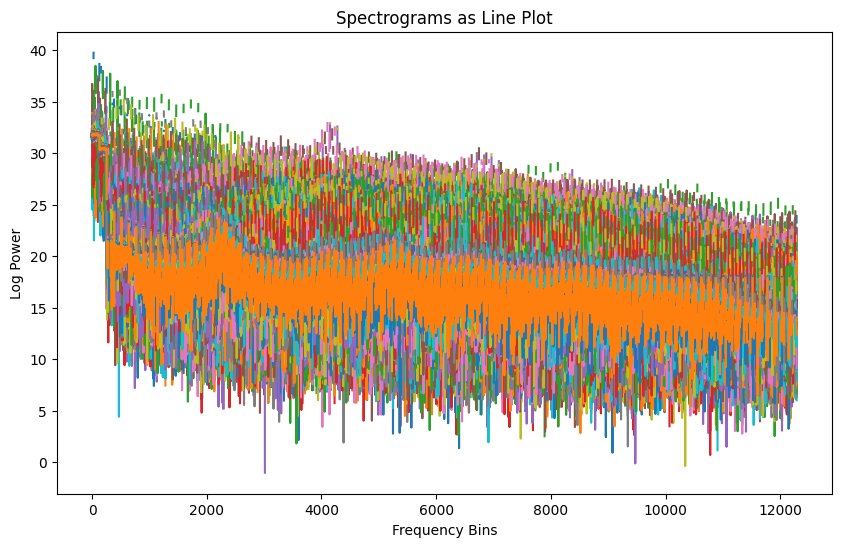

In [8]:
import matplotlib.pyplot as plt

# Ensure there are spectrograms to plot
if all_spectrograms.size > 0:
    plt.figure(figsize=(10, 6))
    for i in range(len(all_spectrograms)):  # Loop through all spectrograms
        plt.plot(all_spectrograms[i].flatten())
    plt.title(f'Spectrograms as Line Plot')
    plt.xlabel('Frequency Bins')
    plt.ylabel('Log Power')
    plt.show()
else:
    print("No spectrograms found in all_spectrograms.")

In [9]:
#display information on Input.npy
print(f"Shape of combined spectrogram array with batch and channel dimensions: {all_spectrograms.shape}")
print(f"Number of files processed: {all_spectrograms.shape[0]}")

# load Input.npy and display information for confirmation
input_data_file_t = np.load(input_filepath)
print(f"Shape of combined spectrogram array Input.npy: {input_data_file_t.shape}")
print(f"Number of files processed: {input_data_file_t.shape[0]}")

Shape of combined spectrogram array with batch and channel dimensions: (2542, 96, 128)
Number of files processed: 2542
Shape of combined spectrogram array Input.npy: (2542, 96, 128)
Number of files processed: 2542
